# IMPORTS

In [272]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier, DMatrix, train as xgb_train
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# Data set Preparation

In [196]:
# Check for missing values
awards_players = pd.read_csv('awards_players.csv')
coaches = pd.read_csv('coaches.csv')
players = pd.read_csv('players.csv')
players_teams = pd.read_csv('players_teams.csv')
series_post = pd.read_csv('series_post.csv')
teams = pd.read_csv('teams.csv')
teams_post = pd.read_csv('teams_post.csv')

## Players

In [199]:
# Drop unnecessary columns only after all calculations are done
players.drop(['firstseason', 'lastseason','deathDate','collegeOther'], axis=1, inplace=True)


In [201]:
players.head()

,bioID,pos,height,weight,college,birthDate
0,abrahta01w,C,74.0,190,George Washington,1975-09-27
1,abrossv01w,F,74.0,169,Connecticut,1980-07-09
2,adairje01w,C,76.0,197,George Washington,1986-12-19
3,adamsda01w,F-C,73.0,239,Texas A&M,1989-02-19
4,adamsjo01w,C,75.0,180,New Mexico,1981-05-24


## Teams

In [204]:
# Assuming the uploaded CSV is already loaded into a dataframe named `teams`
# 1. Win Ratios
teams['win_ratio'] = teams['won'] / teams['GP']
teams.drop(['won'], axis=1, inplace=True)

teams['home_win_ratio'] = teams['homeW'] / (teams['homeW'] + teams['homeL'])
teams.drop(['homeW', 'homeL'], axis=1, inplace=True)

teams['away_win_ratio'] = teams['awayW'] / (teams['awayW'] + teams['awayL'])
teams.drop(['awayW', 'awayL'], axis=1, inplace=True)

teams['conf_win_ratio'] = teams['confW'] / (teams['confW'] + teams['confL'])
teams.drop(['confW', 'confL'], axis=1, inplace=True)

# 2. Scoring Efficiency
teams['off_efficiency'] = teams['o_pts'] / (teams['o_fga'] + teams['o_fta'])
teams.drop(['o_pts', 'o_fga', 'o_fta'], axis=1, inplace=True)

teams['def_efficiency'] = teams['d_pts'] / (teams['d_fga'] + teams['d_fta'])
teams.drop(['d_pts', 'd_fga', 'd_fta'], axis=1, inplace=True)

# 3. Rebounding Metrics
teams['off_reb_percentage'] = teams['o_oreb'] / (teams['o_oreb'] + teams['d_dreb'])
teams.drop(['o_oreb', 'd_dreb'], axis=1, inplace=True)

teams['def_reb_percentage'] = teams['o_dreb'] / (teams['o_dreb'] + teams['d_oreb'])
teams.drop(['o_dreb', 'd_oreb'], axis=1, inplace=True)

# 4. Turnover Ratio
teams['to_ratio'] = teams['o_to'] / teams['GP']

# Assuming the dataframe is named `teams`

# 1. Scoring Contribution
teams['fgm_contribution'] = teams['o_fgm'] * 2 + teams['o_3pm'] * 3
teams['ftm_contribution'] = teams['o_ftm']  # Free throws worth 1 point each
teams['three_point_ratio'] = teams['o_3pm'] / teams['o_3pa']

# Drop the columns used above
teams.drop(['o_fgm', 'o_3pm', 'o_ftm', 'o_3pa'], axis=1, inplace=True)

# 3. Assist-to-Turnover Ratios
teams['off_ast_to_ratio'] = teams['o_asts'] / teams['o_to']
teams['def_ast_to_ratio'] = teams['d_asts'] / teams['d_to']

# Drop assist and turnover columns
teams.drop(['o_asts', 'd_asts', 'o_to', 'd_to'], axis=1, inplace=True)

# 4. Steal and Block Ratios
teams['off_steal_ratio'] = teams['o_stl'] / teams['GP']
teams['off_block_ratio'] = teams['o_blk'] / teams['GP']
teams['def_steal_ratio'] = teams['d_stl'] / teams['GP']
teams['def_block_ratio'] = teams['d_blk'] / teams['GP']

# Drop the corresponding columns
teams.drop(['o_stl', 'o_blk', 'd_stl', 'd_blk'], axis=1, inplace=True)

# 5. Efficiency per Minute
teams['efficiency_per_min'] = (teams['win_ratio'] + teams['off_efficiency'] - teams['def_efficiency']) / teams['min']

# Drop the `min` column as it's been used
teams.drop(['min'], axis=1, inplace=True)

# 6. Points allowed vs. Points scored
teams['points_diff'] = (teams['win_ratio'] * teams['GP'] * teams['off_efficiency']) - (teams['def_efficiency'] * teams['GP'] * teams['win_ratio'])

# Drop any other residual columns
# DivID, seeded,'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB'  are always nan or 0
# arena and name are irrelevant
# lgID is alaway the same WNBA
# 'firstRound','semis', 'finals' to prevent future data leakage
teams.drop(['tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB','d_fgm', 'd_ftm', 'd_3pm', 'd_3pa', 'o_reb', 'd_reb', 'o_pf', 'd_pf', 'lost','divID','arena','lgID','name','seeded','firstRound','semis', 'finals'], axis=1, inplace=True)


In [206]:
teams.head()

,year,tmID,franchID,confID,rank,playoff,GP,attend,win_ratio,home_win_ratio,away_win_ratio,conf_win_ratio,off_efficiency,def_efficiency,off_reb_percentage,def_reb_percentage,to_ratio,fgm_contribution,ftm_contribution,three_point_ratio,off_ast_to_ratio,def_ast_to_ratio,off_steal_ratio,off_block_ratio,def_steal_ratio,def_block_ratio,efficiency_per_min,points_diff
0,9,ATL,ATL,EA,7,N,34,141379,0.117647,0.058824,0.176471,0.100000,0.849480,0.907629,0.282392,0.647627,17.441176,2396,542,0.337793,0.829680,1.219251,8.382353,4.176471,9.117647,3.941176,0.000009,-0.232595
1,10,ATL,ATL,EA,2,Y,34,120737,0.529412,0.705882,0.352941,0.454545,0.898838,0.882334,0.329796,0.707781,17.352941,2520,569,0.304813,0.927119,1.023295,9.676471,3.558824,10.205882,3.911765,0.000079,0.297057
2,1,CHA,CHA,EA,8,N,32,90963,0.250000,0.312500,0.187500,0.238095,0.881452,0.917989,0.314757,0.658996,15.500000,2017,431,0.339378,1.110887,1.399061,6.937500,2.812500,8.093750,3.843750,0.000033,-0.292302
3,2,CHA,CHA,EA,4,Y,32,105525,0.562500,0.687500,0.437500,0.714286,0.890381,0.834302,0.352740,0.650051,14.812500,1951,410,0.357477,0.985232,0.991051,6.781250,3.562500,8.031250,3.875000,0.000095,1.009421
4,3,CHA,CHA,EA,2,Y,32,106670,0.562500,0.687500,0.437500,0.571429,0.913575,0.886902,0.327549,0.688819,12.750000,2173,490,0.400380,1.215686,1.153302,7.531250,3.281250,6.500000,3.218750,0.000091,0.480113


In [208]:
# Use `teams_post` dataframe for augmentation
# 1. Win Ratio
teams_post['win_ratio_post'] = teams_post['W'] / (teams_post['W'] + teams_post['L'])

# 2. Total Games Played
teams_post['total_games_post'] = teams_post['W'] + teams_post['L']

# 3. Winning Margin
teams_post['win_margin_post'] = teams_post['W'] - teams_post['L']

# Drop the columns used for calculations
teams_post.drop(['W', 'L','lgID'], axis=1, inplace=True)
teams_post.fillna(0, inplace=True)

## player_teams

In [211]:
# Use `players_teams` dataframe for augmentation

# 1. Per-Game Metrics
players_teams['points_per_game'] = players_teams['points'] / players_teams['GP']
players_teams['rebounds_per_game'] = (players_teams['oRebounds'] + players_teams['dRebounds']) / players_teams['GP']
players_teams['assists_per_game'] = players_teams['assists'] / players_teams['GP']
players_teams['steals_per_game'] = players_teams['steals'] / players_teams['GP']
players_teams['blocks_per_game'] = players_teams['blocks'] / players_teams['GP']

# Drop columns used for the above calculations
players_teams.drop(['points', 'oRebounds', 'dRebounds', 'assists', 'steals', 'blocks'], axis=1, inplace=True)

# 2. Efficiency Ratios
players_teams['assist_to_turnover_ratio'] = players_teams['assists_per_game'] / players_teams['turnovers']
players_teams['points_per_minute'] = players_teams['points_per_game'] / players_teams['minutes']

# Drop the `turnovers` column
players_teams.drop(['turnovers'], axis=1, inplace=True)

# 3. Postseason Metrics (mirror regular season)
players_teams['post_points_per_game'] = players_teams['PostPoints'] / players_teams['PostGP']
players_teams['post_rebounds_per_game'] = (players_teams['PostoRebounds'] + players_teams['PostdRebounds']) / players_teams['PostGP']
players_teams['post_assists_per_game'] = players_teams['PostAssists'] / players_teams['PostGP']

# Drop the postseason columns used
players_teams.drop(['PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostAssists'], axis=1, inplace=True)

# 4. Player Impact Score
players_teams['player_impact_score'] = (players_teams['points_per_game'] + players_teams['rebounds_per_game'] +
                                        players_teams['assists_per_game'] + players_teams['steals_per_game'] * 2)

# 1. Shooting Efficiency Metrics
players_teams['fg_percentage'] = players_teams['fgMade'] / players_teams['fgAttempted']
players_teams['ft_percentage'] = players_teams['ftMade'] / players_teams['ftAttempted']
players_teams['three_point_percentage'] = players_teams['threeMade'] / players_teams['threeAttempted']

# Drop columns used above
players_teams.drop(['fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade'], axis=1, inplace=True)

# 2. Fouls and Discipline Metrics
# Use `GP` before dropping it
players_teams['foul_rate'] = players_teams['PF'] / players_teams['GP']
players_teams['disqualification_rate'] = players_teams['dq'] / players_teams['GP']

# Drop columns used above
players_teams.drop(['PF', 'dq'], axis=1, inplace=True)

# 3. Postseason Shooting Efficiency
players_teams['post_fg_percentage'] = players_teams['PostfgMade'] / players_teams['PostfgAttempted']
players_teams['post_ft_percentage'] = players_teams['PostftMade'] / players_teams['PostftAttempted']
players_teams['post_three_point_percentage'] = players_teams['PostthreeMade'] / players_teams['PostthreeAttempted']

# Drop postseason shooting columns used
players_teams.drop(['PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade', 
                    'PostthreeAttempted', 'PostthreeMade'], axis=1, inplace=True)

# 4. Postseason Impact Metrics
# Use `PostGP` before dropping it
players_teams['post_rebounds_per_game'] = players_teams['PostRebounds'] / players_teams['PostGP']
players_teams['post_steals_per_game'] = players_teams['PostSteals'] / players_teams['PostGP']
players_teams['post_blocks_per_game'] = players_teams['PostBlocks'] / players_teams['PostGP']
players_teams['post_turnover_rate'] = players_teams['PostTurnovers'] / players_teams['PostGP']
players_teams['post_foul_rate'] = players_teams['PostPF'] / players_teams['PostGP']
players_teams['post_disqualification_rate'] = players_teams['PostDQ'] / players_teams['PostGP']

# Drop the GP columns only after they have been used
players_teams.drop(['PostGP', 'minutes', 'GP', 'GS', 'PostRebounds', 'PostSteals', 'PostBlocks', 
                    'PostTurnovers', 'PostPF', 'PostDQ', 'PostGS', 'PostMinutes','lgID'], axis=1, inplace=True)

players_teams.fillna(0, inplace=True)

In [212]:
players_teams.head()

,playerID,year,stint,tmID,rebounds,points_per_game,rebounds_per_game,assists_per_game,steals_per_game,blocks_per_game,assist_to_turnover_ratio,points_per_minute,post_points_per_game,post_rebounds_per_game,post_assists_per_game,player_impact_score,fg_percentage,ft_percentage,three_point_percentage,foul_rate,disqualification_rate,post_fg_percentage,post_ft_percentage,post_three_point_percentage,post_steals_per_game,post_blocks_per_game,post_turnover_rate,post_foul_rate,post_disqualification_rate
0,abrossv01w,2,0,MIN,174,13.192308,6.692308,2.038462,1.615385,0.346154,0.023982,0.015594,0.000000,0.000000,0.000000,25.153846,0.389078,0.727273,0.250000,2.692308,0.076923,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,abrossv01w,3,0,MIN,146,11.629630,5.407407,2.222222,1.555556,0.370370,0.024155,0.014447,0.000000,0.000000,0.000000,22.370370,0.376582,0.482759,0.333333,2.703704,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,abrossv01w,4,0,MIN,141,10.600000,4.700000,2.733333,1.466667,0.366667,0.030370,0.013384,7.666667,1.666667,1.333333,20.966667,0.392982,0.704082,0.304878,2.633333,0.000000,0.272727,1.0,0.428571,1.333333,0.333333,2.666667,2.666667,0.0
3,abrossv01w,5,0,MIN,74,6.636364,3.363636,2.045455,1.363636,0.090909,0.047569,0.014364,10.000000,4.500000,1.500000,14.772727,0.352518,0.608696,0.377358,1.909091,0.000000,0.347826,0.5,0.250000,0.500000,1.000000,1.500000,3.500000,0.0
4,abrossv01w,6,0,MIN,107,9.806452,3.451613,1.935484,1.548387,0.193548,0.024194,0.012621,0.000000,0.000000,0.000000,18.290323,0.394928,0.726027,0.402439,2.774194,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


## Coaches

In [216]:
# Use `coaches` dataframe for augmentation

# 1. Win Ratios
coaches['win_ratio'] = coaches['won'] / (coaches['won'] + coaches['lost'])
coaches['post_win_ratio'] = coaches['post_wins'] / (coaches['post_wins'] + coaches['post_losses'])

# 2. Total Games Coached
coaches['total_games'] = coaches['won'] + coaches['lost']
coaches['total_post_games'] = coaches['post_wins'] + coaches['post_losses']

# Drop the original columns used for calculations
coaches.drop(['won', 'lost', 'post_wins', 'post_losses','lgID'], axis=1, inplace=True)
coaches.fillna(0, inplace=True)

In [218]:
coaches.head()

,coachID,year,tmID,stint,win_ratio,post_win_ratio,total_games,total_post_games
0,adamsmi01w,5,WAS,0,0.500000,0.333333,34,3
1,adubari99w,1,NYL,0,0.625000,0.571429,32,7
2,adubari99w,2,NYL,0,0.656250,0.500000,32,6
3,adubari99w,3,NYL,0,0.562500,0.500000,32,8
4,adubari99w,4,NYL,0,0.470588,0.000000,34,0


## Awards

In [221]:
awards_players['award'].unique()

array(['All-Star Game Most Valuable Player', 'Coach of the Year',
       'Defensive Player of the Year', 'Kim Perrot Sportsmanship',
       'Kim Perrot Sportsmanship Award', 'Most Improved Player',
       'Most Valuable Player', 'Rookie of the Year',
       'Sixth Woman of the Year', 'WNBA Finals Most Valuable Player',
       'WNBA All-Decade Team', 'WNBA All Decade Team Honorable Mention'],
      dtype=object)

In [223]:
awards_players.loc[awards_players['award'] == 'Kim Perrot Sportsmanship', 'award'] = 'Kim Perrot Sportsmanship Award'

In [225]:
# Define a mapping dictionary for awards and their respective points
award_points_mapping = {
    'Kim Perrot Sportsmanship Award': 0,
    'Most Valuable Player': 15,
    'WNBA Finals Most Valuable Player': 13,
    'WNBA All-Decade Team': 12,
    'All-Star Game Most Valuable Player': 10,
    'Coach of the Year': 9,
    'Defensive Player of the Year': 8,
    'WNBA All Decade Team Honorable Mention': 7,
    'Sixth Woman of the Year': 6,
    'Most Improved Player': 5,
    'Rookie of the Year': 4
}

# Map the 'award' column to the points using the mapping dictionary
awards_players['awardPoints'] = awards_players['award'].map(award_points_mapping)
awards_players.drop(['award'], axis=1, inplace=True)


In [227]:
awards_players.head()

,playerID,year,lgID,awardPoints
0,thompti01w,1,WNBA,10
1,leslili01w,2,WNBA,10
2,leslili01w,3,WNBA,10
3,teaslni01w,4,WNBA,10
4,swoopsh01w,6,WNBA,10


# Big Merge

In [230]:
# Correct the prefix handling and ensure 'playerID' is retained correctly

coaches_prefixed = coaches.add_prefix('coaches_')
players_prefixed = players.add_prefix('players_')
players_teams_prefixed = players_teams.add_prefix('players_teams_')
teams_prefixed = teams.add_prefix('teams_')
teams_post_prefixed = teams_post.add_prefix('teams_post_')
awards_players_prefixed = awards_players.add_prefix('awards_players_')

# Remove the prefix from columns used for merging
teams_prefixed.rename(columns={'teams_tmID': 'tmID', 'teams_year': 'year'}, inplace=True)
teams_post_prefixed.rename(columns={'teams_post_tmID': 'tmID', 'teams_post_year': 'year'}, inplace=True)
coaches_prefixed.rename(columns={'coaches_tmID': 'tmID', 'coaches_year': 'year'}, inplace=True)
players_teams_prefixed.rename(columns={'players_teams_tmID': 'tmID', 'players_teams_year': 'year', 'players_teams_playerID': 'playerID'}, inplace=True)
awards_players_prefixed.rename(columns={'awards_players_playerID': 'playerID', 'awards_players_year': 'year'}, inplace=True)

# Step 2: Merge teams with teams_post
team_data = pd.merge(teams_prefixed, teams_post_prefixed, how='left', on=['tmID', 'year'])

# Step 3: Merge players with players_teams
players_prefixed.rename(columns={'players_bioID': 'playerID'}, inplace=True)
players_prefixed.rename(columns={'players_playerID': 'playerID'}, inplace=True)

# Step 3: Merge players with players_teams correctly using the right columns
players_teams_combined = pd.merge(players_teams_prefixed, players_prefixed, how='left', on='playerID')

# Continue with the rest of the merge steps as defined
# Step 4: Aggregate player stats by team
player_stats_by_team = players_teams_combined.groupby(['tmID', 'year']).agg({
    'players_teams_points_per_game': 'sum',
    'players_teams_rebounds_per_game': 'sum'
}).reset_index()

# Step 5: Merge team_data with player_stats_by_team
team_data = pd.merge(team_data, player_stats_by_team, how='left', on=['tmID', 'year'])

# Step 6: Merge team_data with coaches
team_data = pd.merge(team_data, coaches_prefixed, how='left', on=['tmID', 'year'])

# Step 7: Merge awards_players with players_teams
awards_with_teams = pd.merge(awards_players_prefixed, players_teams_prefixed, how='left', on=['playerID', 'year'])

# Step 8: Aggregate awards by team
awards_by_team = awards_with_teams.groupby(['tmID', 'year']).agg({
    'awards_players_awardPoints': 'sum'
}).reset_index()

# Step 9: Merge awards_by_team with team_data
team_data = pd.merge(team_data, awards_by_team, how='left', on=['tmID', 'year'])

# Step 10: Fill missing values in num_awards and other columns
team_data['awards_players_awardPoints'].fillna(0, inplace=True)
team_data.fillna(0, inplace=True)

C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\52241429.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  team_data['awards_players_awardPoints'].fillna(0, inplace=True)


In [232]:
team_data.head()

,year,tmID,teams_franchID,teams_confID,teams_rank,teams_playoff,teams_GP,teams_attend,teams_win_ratio,teams_home_win_ratio,teams_away_win_ratio,teams_conf_win_ratio,teams_off_efficiency,teams_def_efficiency,teams_off_reb_percentage,teams_def_reb_percentage,teams_to_ratio,teams_fgm_contribution,teams_ftm_contribution,teams_three_point_ratio,teams_off_ast_to_ratio,teams_def_ast_to_ratio,teams_off_steal_ratio,teams_off_block_ratio,teams_def_steal_ratio,teams_def_block_ratio,teams_efficiency_per_min,teams_points_diff,teams_post_win_ratio_post,teams_post_total_games_post,teams_post_win_margin_post,players_teams_points_per_game,players_teams_rebounds_per_game,coaches_coachID,coaches_stint,coaches_win_ratio,coaches_post_win_ratio,coaches_total_games,coaches_total_post_games,awards_players_awardPoints
0,9,ATL,ATL,EA,7,N,34,141379,0.117647,0.058824,0.176471,0.100000,0.849480,0.907629,0.282392,0.647627,17.441176,2396,542,0.337793,0.829680,1.219251,8.382353,4.176471,9.117647,3.941176,0.000009,-0.232595,0.0,0.0,0.0,90.280886,42.711812,meadoma99w,0,0.117647,0.0,34,0,0.0
1,10,ATL,ATL,EA,2,Y,34,120737,0.529412,0.705882,0.352941,0.454545,0.898838,0.882334,0.329796,0.707781,17.352941,2520,569,0.304813,0.927119,1.023295,9.676471,3.558824,10.205882,3.911765,0.000079,0.297057,0.0,2.0,-2.0,95.379269,41.553204,meadoma99w,0,0.529412,0.0,34,2,4.0
2,1,CHA,CHA,EA,8,N,32,90963,0.250000,0.312500,0.187500,0.238095,0.881452,0.917989,0.314757,0.658996,15.500000,2017,431,0.339378,1.110887,1.399061,6.937500,2.812500,8.093750,3.843750,0.000033,-0.292302,0.0,0.0,0.0,83.889925,34.508183,dunntr01wc,0,0.250000,0.0,32,0,0.0
3,2,CHA,CHA,EA,4,Y,32,105525,0.562500,0.687500,0.437500,0.714286,0.890381,0.834302,0.352740,0.650051,14.812500,1951,410,0.357477,0.985232,0.991051,6.781250,3.562500,8.031250,3.875000,0.000095,1.009421,0.5,8.0,0.0,68.969460,34.470022,donovan99w,0,0.562500,0.5,32,8,0.0
4,3,CHA,CHA,EA,2,Y,32,106670,0.562500,0.687500,0.437500,0.571429,0.913575,0.886902,0.327549,0.688819,12.750000,2173,490,0.400380,1.215686,1.153302,7.531250,3.281250,6.500000,3.218750,0.000091,0.480113,0.0,2.0,-2.0,74.023695,32.655009,donovan99w,0,0.562500,0.0,32,2,0.0


In [250]:
team_data.columns

Index(['year', 'tmID', 'teams_franchID', 'teams_confID', 'teams_rank',
       'teams_playoff', 'teams_GP', 'teams_attend', 'teams_win_ratio',
       'teams_home_win_ratio', 'teams_away_win_ratio', 'teams_conf_win_ratio',
       'teams_off_efficiency', 'teams_def_efficiency',
       'teams_off_reb_percentage', 'teams_def_reb_percentage',
       'teams_to_ratio', 'teams_fgm_contribution', 'teams_ftm_contribution',
       'teams_three_point_ratio', 'teams_off_ast_to_ratio',
       'teams_def_ast_to_ratio', 'teams_off_steal_ratio',
       'teams_off_block_ratio', 'teams_def_steal_ratio',
       'teams_def_block_ratio', 'teams_efficiency_per_min',
       'teams_points_diff', 'teams_post_win_ratio_post',
       'teams_post_total_games_post', 'teams_post_win_margin_post',
       'players_teams_points_per_game', 'players_teams_rebounds_per_game',
       'coaches_coachID', 'coaches_stint', 'coaches_win_ratio',
       'coaches_post_win_ratio', 'coaches_total_games',
       'coaches_total_post_ga

In [252]:
team_data_no_str = team_data.drop(['tmID', 'teams_franchID', 'teams_confID','teams_playoff','coaches_coachID'], axis=1)

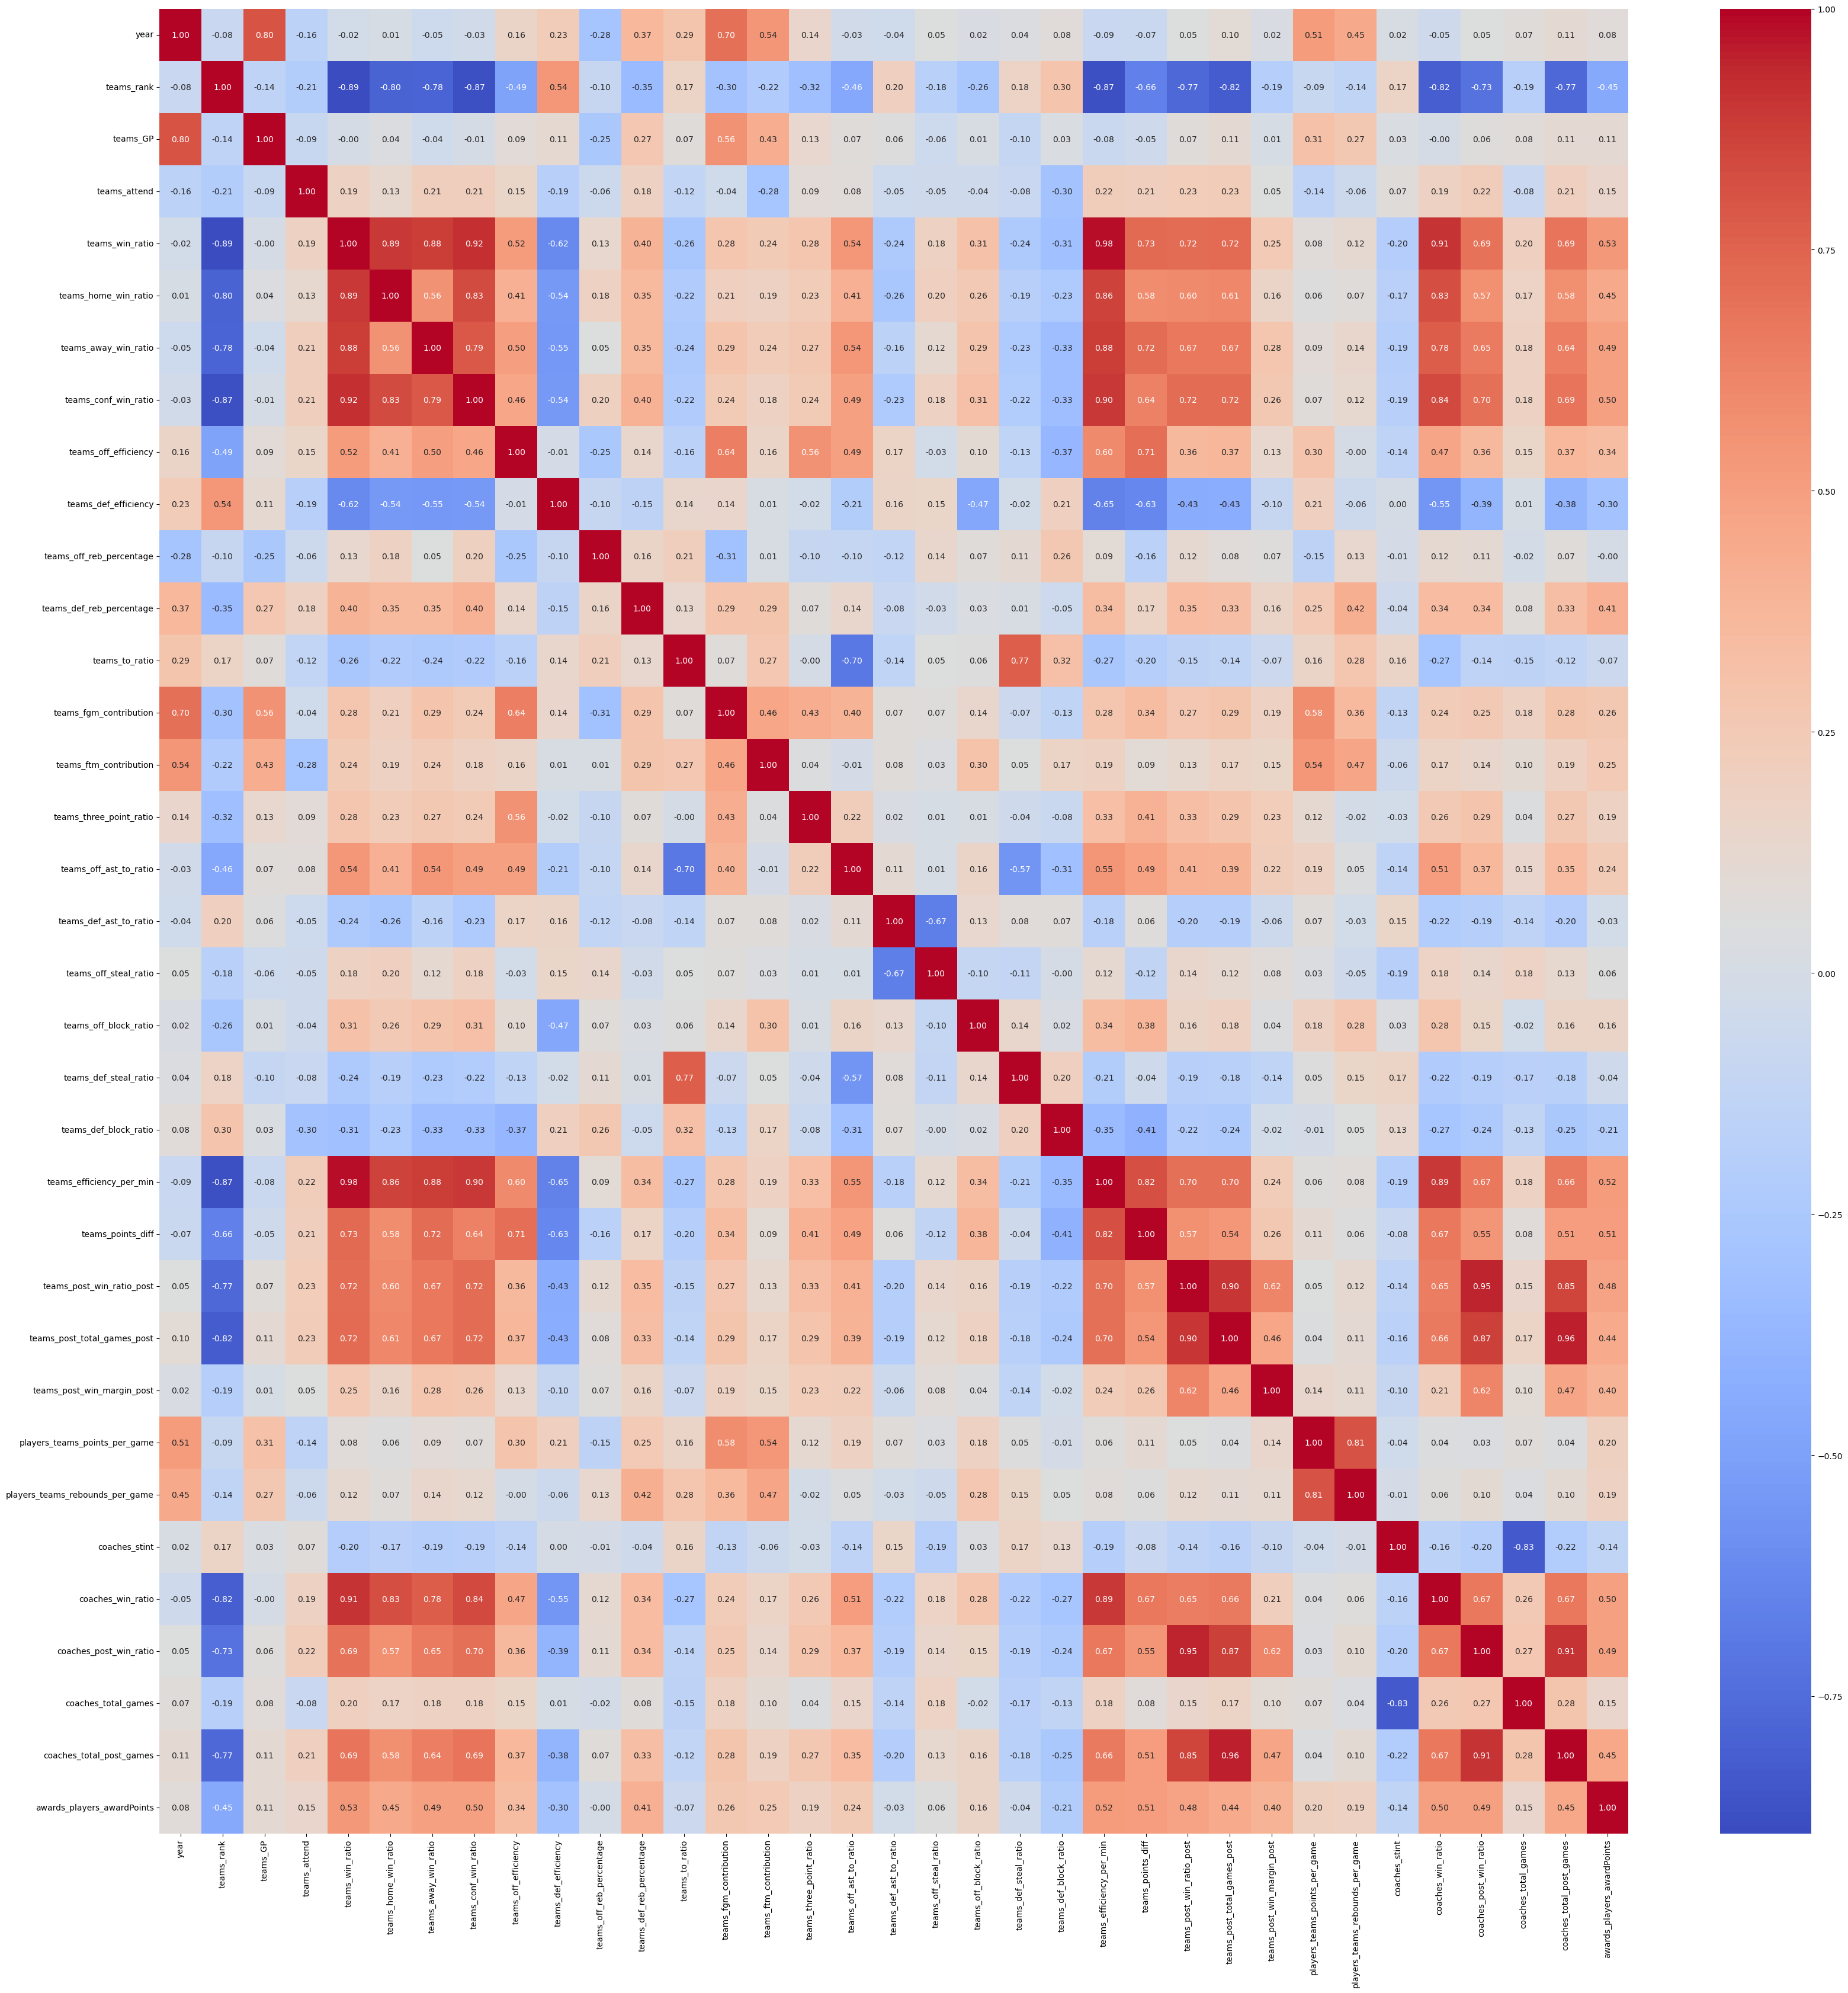

In [254]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = team_data_no_str.corr()

# Save the correlation matrix as a CSV file
corr_matrix.to_csv("correlation_matrix.csv")

# Plot heatmap for correlation
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [256]:
# Find columns with high correlation (|correlation| >= 0.75) to determine which to drop
columns_to_drop = set()

# Iterate through the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= 0.90:
            # Drop the second column in the highly correlated pair
            col2 = corr_matrix.columns[j]
            columns_to_drop.add(col2)

# Create a reduced dataframe by dropping these columns
reduced_data = team_data.drop(columns=list(columns_to_drop))

# Generate new interaction terms for remaining columns
# Select numerical columns for interaction term creation
remaining_numerical_columns = reduced_data.select_dtypes(include=[np.number]).columns

print(columns_to_drop)


{'coaches_total_post_games', 'teams_post_total_games_post', 'teams_efficiency_per_min', 'teams_conf_win_ratio', 'coaches_win_ratio', 'coaches_post_win_ratio'}


In [258]:
reduced_data.columns

Index(['year', 'tmID', 'teams_franchID', 'teams_confID', 'teams_rank',
       'teams_playoff', 'teams_GP', 'teams_attend', 'teams_win_ratio',
       'teams_home_win_ratio', 'teams_away_win_ratio', 'teams_off_efficiency',
       'teams_def_efficiency', 'teams_off_reb_percentage',
       'teams_def_reb_percentage', 'teams_to_ratio', 'teams_fgm_contribution',
       'teams_ftm_contribution', 'teams_three_point_ratio',
       'teams_off_ast_to_ratio', 'teams_def_ast_to_ratio',
       'teams_off_steal_ratio', 'teams_off_block_ratio',
       'teams_def_steal_ratio', 'teams_def_block_ratio', 'teams_points_diff',
       'teams_post_win_ratio_post', 'teams_post_win_margin_post',
       'players_teams_points_per_game', 'players_teams_rebounds_per_game',
       'coaches_coachID', 'coaches_stint', 'coaches_total_games',
       'awards_players_awardPoints'],
      dtype='object')

In [294]:
# Step 1: Sort the data by team ID and year
reduced_data_sorted = reduced_data.sort_values(by=['tmID', 'year'])

# Step 2: Shift the `teams_playoff_Y` column by -1 year within each team group
reduced_data_sorted['next_season_playoff'] = reduced_data_sorted.groupby('tmID')['teams_playoff'].shift(-1)

# Sort data by `year` and `tmID`
reduced_data_sorted['teams_playoff'] = reduced_data_sorted['teams_playoff'].str.strip().map({'Y': 1, 'N': 0}).fillna(0).astype(int)
reduced_data_sorted['next_season_playoff'] = reduced_data_sorted['next_season_playoff'].str.strip().map({'Y': 1, 'N': 0}).fillna(0).astype(int)
# Initialize an empty list to store predictions and corresponding years
all_predictions = []
all_actuals = []

# List of years in the dataset
years = reduced_data_sorted['year'].unique()

In [296]:
# Initialize lists to store overall predictions and actuals
all_predictions = []
all_actuals = []

# Sort years in ascending order
years = reduced_data_sorted['year'].unique()
years.sort()

# Number of epochs
epochs = 10

# Initialize the model once outside the loops
clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    reg_alpha=1.0,        # Increased L1 regularization term on weights
    reg_lambda=1.0,       # Increased L2 regularization term on weights
    learning_rate=0.05,   # Reduced learning rate
    max_depth=10,          # Reduced tree depth
    min_child_weight=5,   # Increased minimum sum of instance weight (hessian) needed in a child
    subsample=0.8,        # Subsample ratio of the training instances
    colsample_bytree=0.8  # Subsample ratio of columns when constructing each tree
)

# Initialize empty DataFrames to accumulate training data
X_cumulative = pd.DataFrame()
y_cumulative = pd.Series(dtype=int)

# Placeholder for the previous model
prev_model = None

# Total number of boosting rounds added so far
total_boosting_rounds = 0
max_total_boosting_rounds = 1000  # Maximum total number of trees allowed

# Rolling training and prediction loop for multiple epochs
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    epoch_predictions = []
    epoch_actuals = []

    # Adjust learning rate over epochs (learning rate schedule)
    current_learning_rate = clf.get_params()['learning_rate'] * (0.5 ** epoch)
    clf.set_params(learning_rate=current_learning_rate)

    for i in range(len(years) - 1):  # Exclude the last year for testing
        # Define the training years and testing year
        train_years = years[:i+1]  # Accumulate data up to the current year
        test_year = years[i + 1]

        # Split data into training and testing sets based on years
        train_data = reduced_data_sorted[reduced_data_sorted['year'].isin(train_years)]
        test_data = reduced_data_sorted[reduced_data_sorted['year'] == test_year]
        # Encode next_season_playoff as binary values
        train_data['next_season_playoff'] = train_data['next_season_playoff']
        test_data['next_season_playoff'] = test_data['next_season_playoff']

        # Define X and y for training and testing
        X_train = train_data.drop(columns=['next_season_playoff', 'year', 'tmID','teams_confID','teams_franchID','coaches_coachID'])
        y_train = train_data['next_season_playoff'].astype(int).fillna(0)
        X_test = test_data.drop(columns=['next_season_playoff', 'year', 'tmID','teams_confID','teams_franchID','coaches_coachID'])
        y_test = test_data['next_season_playoff'].astype(int).fillna(0)

        X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
        X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)
        X_cumulative = X_cumulative.apply(pd.to_numeric, errors='coerce').fillna(0)


        # Identify postseason columns and drop them to prevent data leakage
        postseason_columns = [col for col in X_train.columns if 'post' in col.lower()]
        X_train = X_train.drop(columns=postseason_columns)
        X_test = X_test.drop(columns=postseason_columns)

        # Reset index to avoid alignment issues
        X_train.reset_index(drop=True, inplace=True)
        y_train.reset_index(drop=True, inplace=True)
        X_test.reset_index(drop=True, inplace=True)
        y_test.reset_index(drop=True, inplace=True)

        # Accumulate training data
        X_cumulative = pd.concat([X_cumulative, X_train], ignore_index=True)
        y_cumulative = pd.concat([y_cumulative, y_train], ignore_index=True)

        # Handle class imbalance by adjusting scale_pos_weight
        class_counts = y_cumulative.value_counts()
        if len(class_counts) > 1 and class_counts[1] > 0:
            scale_pos_weight = class_counts[0] / class_counts[1]
        else:
            scale_pos_weight = 1

        # Update the model's parameters
        clf.set_params(scale_pos_weight=scale_pos_weight)

        # Convert data to DMatrix
        dtrain = DMatrix(data=X_cumulative, label=y_cumulative)
        dtest = DMatrix(data=X_test)

        # Set training parameters
        params = clf.get_xgb_params()
        params['scale_pos_weight'] = scale_pos_weight
        params['learning_rate'] = current_learning_rate

        # Prepare evaluation set for early stopping
        val_size = min(1000, int(0.1 * len(X_cumulative)))  # Use 10% of data or up to 1000 samples
        if val_size >= 10:
            X_val = X_cumulative.iloc[-val_size:]
            y_val = y_cumulative.iloc[-val_size:]
            dval = DMatrix(data=X_val, label=y_val)
            evals = [(dtrain, 'train'), (dval, 'validation')]
            early_stopping_rounds = 5
        else:
            evals = [(dtrain, 'train')]
            early_stopping_rounds = None

        # Limit the number of boosting rounds
        remaining_boosting_rounds = max(0, max_total_boosting_rounds - total_boosting_rounds)
        num_boost_round = min(10, remaining_boosting_rounds)
        if num_boost_round == 0:
            print("Maximum number of trees reached. Skipping further training.")
            break  # Exit the loop or continue without training

        total_boosting_rounds += num_boost_round

        # Train the model incrementally
        bst = xgb_train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            xgb_model=prev_model,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )

        # Save the model for next iteration
        prev_model = bst

        # Make predictions on the test data
        y_pred_proba = bst.predict(dtest)
        y_pred = (y_pred_proba >= 0.5).astype(int)

        # Store the predictions and actuals for overall evaluation
        all_predictions.extend(y_pred)
        all_actuals.extend(y_test)
        epoch_predictions.extend(y_pred)
        epoch_actuals.extend(y_test)

        # Compute metrics for the current year
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        try:
            auc_score = roc_auc_score(y_test, y_pred_proba)
        except ValueError:
            auc_score = np.nan

        # Print metrics for the current year
        print(f"Year {train_years[-1]} -> Year {test_year} | "
              f"Accuracy: {accuracy:.2f} | F1-Score: {f1:.2f} | "
              f"AUC: {auc_score if not np.isnan(auc_score) else 'N/A'}")

    # Compute and print metrics for the current epoch
    if len(epoch_actuals) == 0:
        print(f"Epoch {epoch + 1} Summary | No predictions made.")
    else:
        epoch_accuracy = accuracy_score(epoch_actuals, epoch_predictions)
        epoch_f1 = f1_score(epoch_actuals, epoch_predictions, zero_division=0)
        try:
            epoch_auc = roc_auc_score(epoch_actuals, [1 if pred == 1 else 0 for pred in epoch_predictions])
        except ValueError:
            epoch_auc = np.nan

        print(f"Epoch {epoch + 1} Summary | "
              f"Accuracy: {epoch_accuracy:.2f} | F1-Score: {epoch_f1:.2f} | "
              f"AUC: {epoch_auc if not np.isnan(epoch_auc) else 'N/A'}")
        print(f"Total Boosting Rounds So Far: {total_boosting_rounds}")

    # Check if maximum number of trees has been reached
    if total_boosting_rounds >= max_total_boosting_rounds:
        print("Reached maximum total boosting rounds. Ending training.")
        break  # Exit the epochs loop

# Calculate overall metrics across all epochs and years
if len(all_actuals) == 0:
    print("No predictions were made during training.")
else:
    overall_accuracy = accuracy_score(all_actuals, all_predictions)
    overall_f1 = f1_score(all_actuals, all_predictions, zero_division=0)
    try:
        overall_auc = roc_auc_score(all_actuals, [1 if pred == 1 else 0 for pred in all_predictions])
    except ValueError:
        overall_auc = np.nan

    print(f"\nOverall Prediction Metrics | "
          f"Accuracy: {overall_accuracy:.2f} | F1-Score: {overall_f1:.2f} | "
          f"AUC: {overall_auc if not np.isnan(overall_auc) else 'N/A'}")



Epoch 1/10
Year 1 -> Year 2 | Accuracy: 0.56 | F1-Score: 0.71 | AUC: 0.5
Year 2 -> Year 3 | Accuracy: 0.74 | F1-Score: 0.71 | AUC: 0.7619047619047621


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 3 -> Year 4 | Accuracy: 0.44 | F1-Score: 0.61 | AUC: 0.3412698412698413
Year 4 -> Year 5 | Accuracy: 0.65 | F1-Score: 0.77 | AUC: 0.803030303030303


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 5 -> Year 6 | Accuracy: 0.73 | F1-Score: 0.78 | AUC: 0.6851851851851851
Year 6 -> Year 7 | Accuracy: 0.60 | F1-Score: 0.73 | AUC: 0.7857142857142857


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 7 -> Year 8 | Accuracy: 0.64 | F1-Score: 0.71 | AUC: 0.5416666666666667
Year 8 -> Year 9 | Accuracy: 0.47 | F1-Score: 0.60 | AUC: 0.5357142857142857


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 9 -> Year 10 | Accuracy: 0.25 | F1-Score: 0.00 | AUC: 0.19999999999999996
Epoch 1 Summary | Accuracy: 0.57 | F1-Score: 0.66 | AUC: 0.5711838599162542
Total Boosting Rounds So Far: 90

Epoch 2/10
Year 1 -> Year 2 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 2 -> Year 3 | Accuracy: 0.95 | F1-Score: 0.92 | AUC: 1.0
Year 3 -> Year 4 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 4 -> Year 5 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0
Year 5 -> Year 6 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 6 -> Year 7 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0
Year 7 -> Year 8 | Accuracy: 0.93 | F1-Score: 0.94 | AUC: 0.9583333333333334


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 8 -> Year 9 | Accuracy: 0.60 | F1-Score: 0.67 | AUC: 0.7499999999999999
Year 9 -> Year 10 | Accuracy: 0.25 | F1-Score: 0.00 | AUC: 0.2666666666666667
Epoch 2 Summary | Accuracy: 0.86 | F1-Score: 0.87 | AUC: 0.8637228778073849
Total Boosting Rounds So Far: 180

Epoch 3/10


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 1 -> Year 2 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0
Year 2 -> Year 3 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 3 -> Year 4 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0
Year 4 -> Year 5 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 5 -> Year 6 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0
Year 6 -> Year 7 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 7 -> Year 8 | Accuracy: 0.93 | F1-Score: 0.94 | AUC: 1.0
Year 8 -> Year 9 | Accuracy: 0.87 | F1-Score: 0.88 | AUC: 0.8392857142857142


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 9 -> Year 10 | Accuracy: 0.25 | F1-Score: 0.00 | AUC: 0.2666666666666667
Epoch 3 Summary | Accuracy: 0.90 | F1-Score: 0.90 | AUC: 0.8980776551199088
Total Boosting Rounds So Far: 270

Epoch 4/10
Year 1 -> Year 2 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 2 -> Year 3 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0
Year 3 -> Year 4 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 4 -> Year 5 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0
Year 5 -> Year 6 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 6 -> Year 7 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0
Year 7 -> Year 8 | Accuracy: 0.93 | F1-Score: 0.94 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 8 -> Year 9 | Accuracy: 0.87 | F1-Score: 0.88 | AUC: 0.8392857142857142
Year 9 -> Year 10 | Accuracy: 0.25 | F1-Score: 0.00 | AUC: 0.2666666666666667
Epoch 4 Summary | Accuracy: 0.90 | F1-Score: 0.90 | AUC: 0.8980776551199088
Total Boosting Rounds So Far: 360

Epoch 5/10


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 1 -> Year 2 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0
Year 2 -> Year 3 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 3 -> Year 4 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0
Year 4 -> Year 5 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 5 -> Year 6 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0
Year 6 -> Year 7 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 7 -> Year 8 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 8 -> Year 9 | Accuracy: 0.87 | F1-Score: 0.88 | AUC: 0.8392857142857142


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 9 -> Year 10 | Accuracy: 0.25 | F1-Score: 0.00 | AUC: 0.2666666666666667
Epoch 5 Summary | Accuracy: 0.90 | F1-Score: 0.91 | AUC: 0.9048344118766655
Total Boosting Rounds So Far: 450

Epoch 6/10


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 1 -> Year 2 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 2 -> Year 3 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 3 -> Year 4 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 4 -> Year 5 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 5 -> Year 6 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 6 -> Year 7 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 7 -> Year 8 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 8 -> Year 9 | Accuracy: 0.87 | F1-Score: 0.88 | AUC: 0.8392857142857142


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 9 -> Year 10 | Accuracy: 0.25 | F1-Score: 0.00 | AUC: 0.2666666666666667
Epoch 6 Summary | Accuracy: 0.90 | F1-Score: 0.91 | AUC: 0.9048344118766655
Total Boosting Rounds So Far: 540

Epoch 7/10


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 1 -> Year 2 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 2 -> Year 3 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 3 -> Year 4 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 4 -> Year 5 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 5 -> Year 6 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 6 -> Year 7 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Year 7 -> Year 8 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0
Year 8 -> Year 9 | Accuracy: 0.87 | F1-Score: 0.88 | AUC: 0.8392857142857142


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 9 -> Year 10 | Accuracy: 0.25 | F1-Score: 0.00 | AUC: 0.2666666666666667
Epoch 7 Summary | Accuracy: 0.90 | F1-Score: 0.91 | AUC: 0.9048344118766655
Total Boosting Rounds So Far: 630

Epoch 8/10


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 1 -> Year 2 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 2 -> Year 3 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 3 -> Year 4 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 4 -> Year 5 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 5 -> Year 6 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 6 -> Year 7 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 7 -> Year 8 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 8 -> Year 9 | Accuracy: 0.87 | F1-Score: 0.88 | AUC: 0.8392857142857142


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 9 -> Year 10 | Accuracy: 0.25 | F1-Score: 0.00 | AUC: 0.2666666666666667
Epoch 8 Summary | Accuracy: 0.90 | F1-Score: 0.91 | AUC: 0.9048344118766655
Total Boosting Rounds So Far: 720

Epoch 9/10


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 1 -> Year 2 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 2 -> Year 3 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 3 -> Year 4 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 4 -> Year 5 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 5 -> Year 6 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 6 -> Year 7 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 7 -> Year 8 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 8 -> Year 9 | Accuracy: 0.87 | F1-Score: 0.88 | AUC: 0.8392857142857142


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 9 -> Year 10 | Accuracy: 0.25 | F1-Score: 0.00 | AUC: 0.2666666666666667
Epoch 9 Summary | Accuracy: 0.90 | F1-Score: 0.91 | AUC: 0.9048344118766655
Total Boosting Rounds So Far: 810

Epoch 10/10


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 1 -> Year 2 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 2 -> Year 3 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 3 -> Year 4 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 4 -> Year 5 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 5 -> Year 6 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 6 -> Year 7 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 7 -> Year 8 | Accuracy: 1.00 | F1-Score: 1.00 | AUC: 1.0


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 8 -> Year 9 | Accuracy: 0.87 | F1-Score: 0.88 | AUC: 0.8392857142857142


C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['next_season_playoff'] = train_data['next_season_playoff']
C:\Users\nakaj\AppData\Local\Temp\ipykernel_17788\3255591599.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['next_season_playoff'] = test_data['next_season_playoff']


Year 9 -> Year 10 | Accuracy: 0.25 | F1-Score: 0.00 | AUC: 0.2666666666666667
Epoch 10 Summary | Accuracy: 0.90 | F1-Score: 0.91 | AUC: 0.9048344118766655
Total Boosting Rounds So Far: 900

Overall Prediction Metrics | Accuracy: 0.86 | F1-Score: 0.87 | AUC: 0.8660068519223448


In [298]:
X_train, X_test, y_train, y_test = train_test_split(reduced_data_sorted.drop(columns=['next_season_playoff','year','tmID','teams_confID','teams_franchID','coaches_coachID']), reduced_data_sorted['next_season_playoff'], test_size=0.2, random_state=42)

In [300]:


# Create the decision tree classifier
clf = DecisionTreeClassifier(random_state=100, min_samples_split=10, min_samples_leaf=5)

# Train the model
clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=10,
                       random_state=100)

In [302]:
# Create and train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Accuracy: 0.5454545454545454
              precision    recall  f1-score   support

           0       0.52      0.69      0.59        16
           1       0.58      0.41      0.48        17

    accuracy                           0.55        33
   macro avg       0.55      0.55      0.54        33
weighted avg       0.55      0.55      0.54        33



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [304]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Accuracy: 0.6060606060606061
              precision    recall  f1-score   support

           0       0.57      0.75      0.65        16
           1       0.67      0.47      0.55        17

    accuracy                           0.61        33
   macro avg       0.62      0.61      0.60        33
weighted avg       0.62      0.61      0.60        33



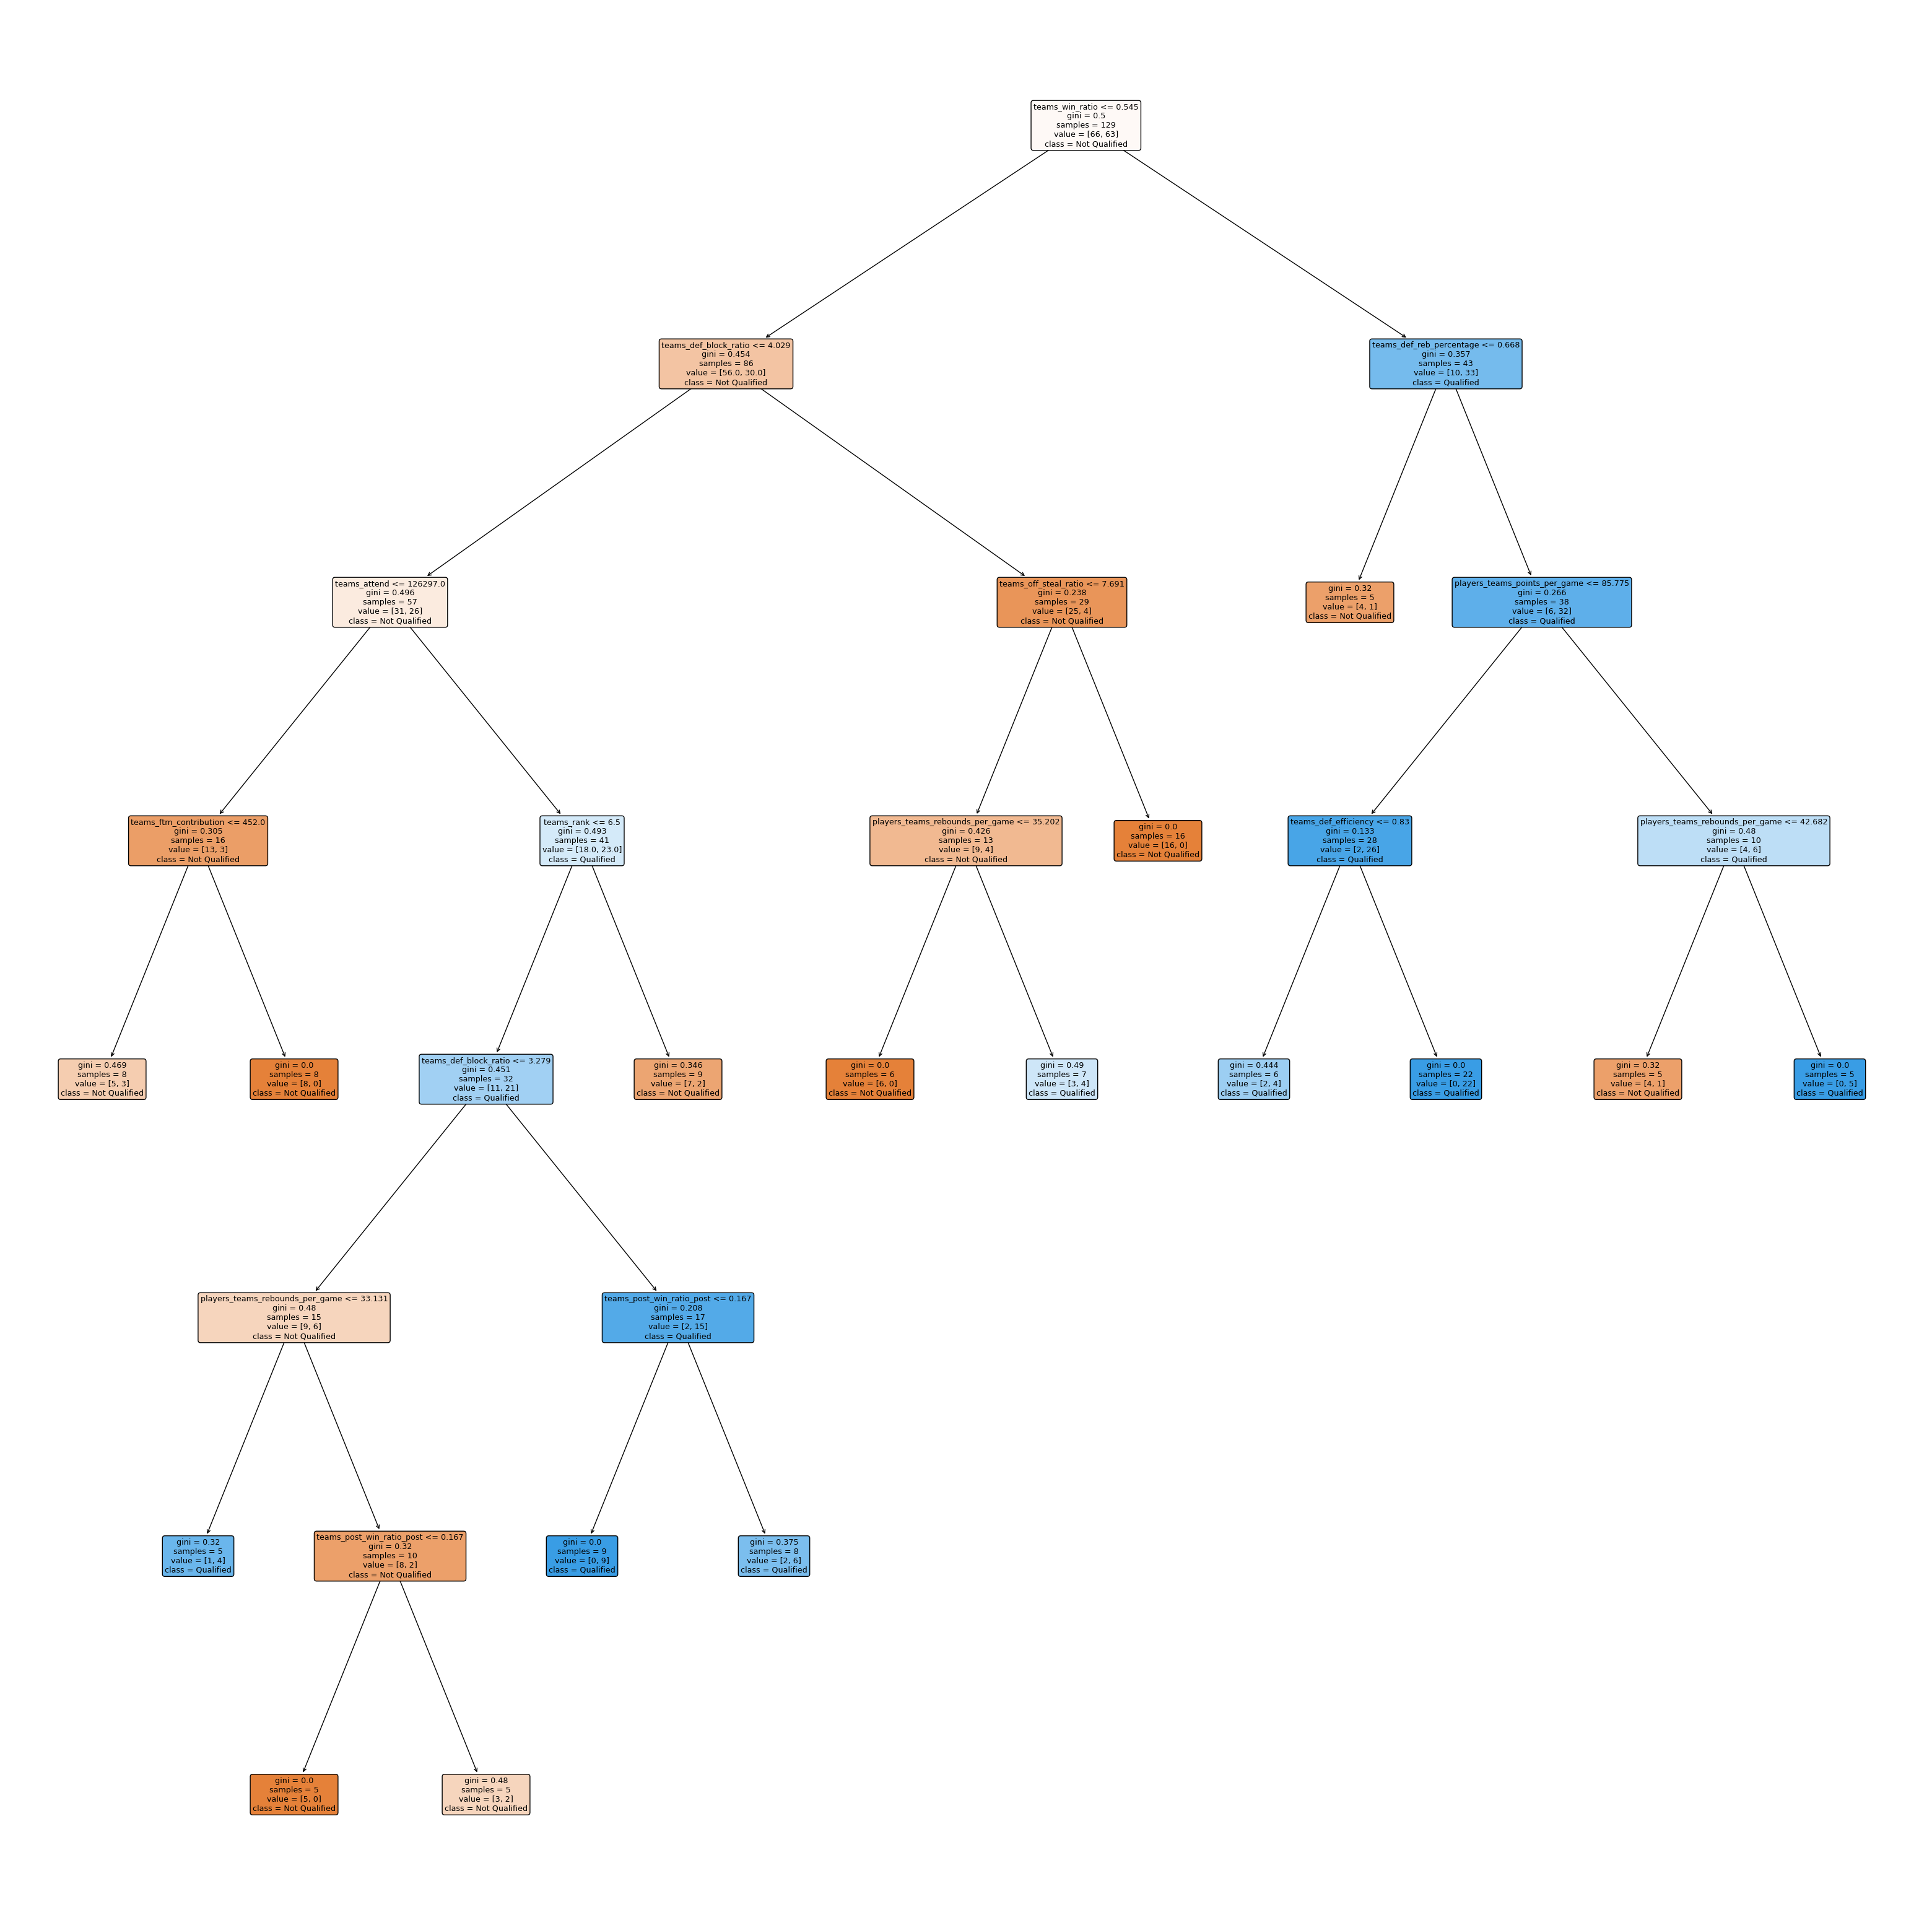

In [308]:
# Plot the decision tree using matplotlib
plt.figure(figsize=(40,40))
tree.plot_tree(clf, feature_names=X_train.columns, class_names=['Not Qualified', 'Qualified'], filled=True, rounded=True)
plt.show()


In [310]:
# Train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Feature importance for Random Forests
rf_feature_importances = pd.DataFrame(rf_clf.feature_importances_,
                                      index=X_train.columns,
                                      columns=['importance']).sort_values('importance', ascending=False)

In [312]:
y_pred = rf_clf.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

print(rf_feature_importances)

Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.65      0.69      0.67        16
           1       0.69      0.65      0.67        17

    accuracy                           0.67        33
   macro avg       0.67      0.67      0.67        33
weighted avg       0.67      0.67      0.67        33

                                 importance
teams_win_ratio                    0.056657
teams_points_diff                  0.056513
teams_off_reb_percentage           0.054745
teams_attend                       0.052266
teams_def_reb_percentage           0.045130
teams_def_efficiency               0.045036
teams_off_block_ratio              0.044949
teams_off_ast_to_ratio             0.043846
teams_def_ast_to_ratio             0.041553
teams_def_steal_ratio              0.038327
teams_def_block_ratio              0.037707
teams_off_steal_ratio              0.036964
teams_three_point_ratio            0.035401
teams_home_win_ratio        

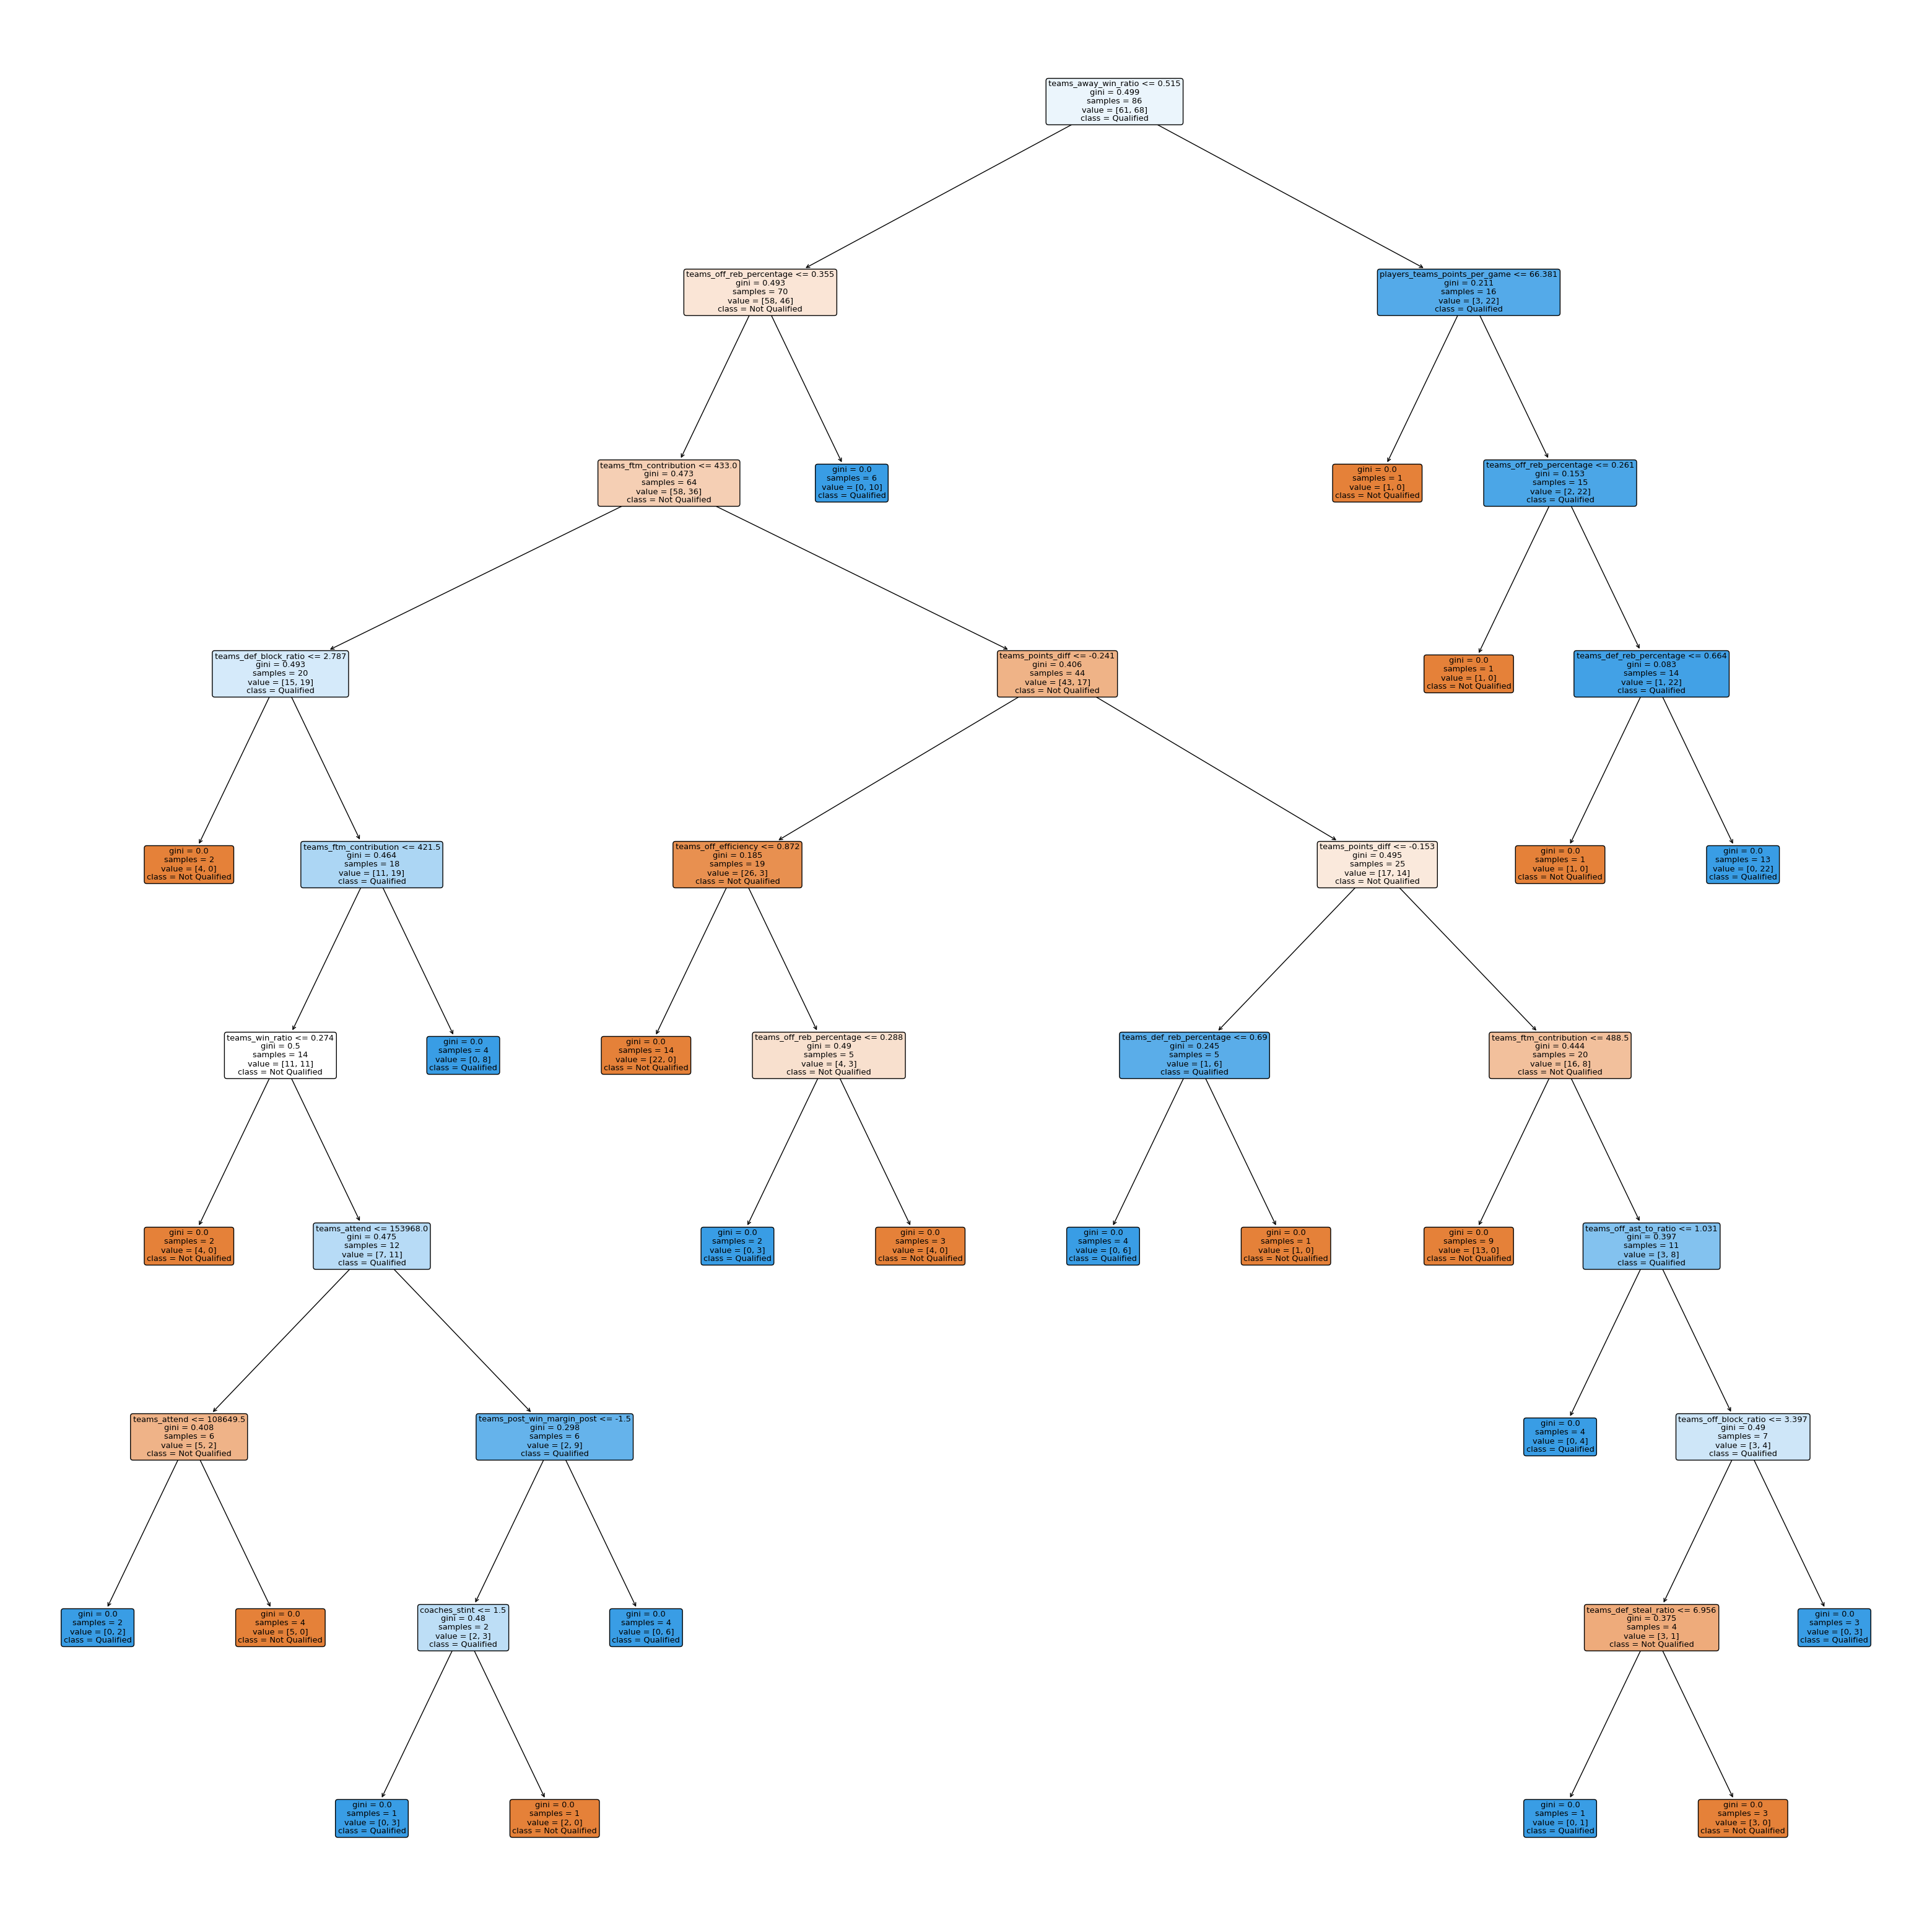

In [314]:
import matplotlib.pyplot as plt
from sklearn import tree
# Extract a single tree from the Random Forest (e.g., the first tree)
single_tree = rf_clf.estimators_[0]

# Plot the single decision tree from the random forest
plt.figure(figsize=(40, 40))
tree.plot_tree(single_tree, feature_names=X_train.columns, class_names=['Not Qualified', 'Qualified'], filled=True, rounded=True)
plt.show()


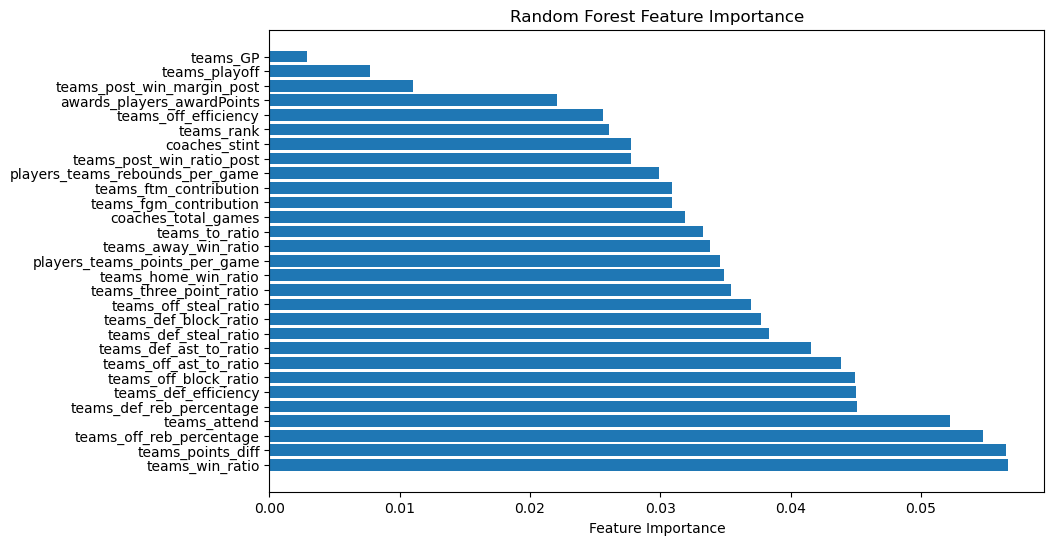

In [316]:
# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(rf_feature_importances.index, rf_feature_importances['importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()


In [318]:
# Check feature importance
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)


                                 importance
teams_win_ratio                    0.243205
players_teams_rebounds_per_game    0.186641
teams_def_block_ratio              0.183995
teams_def_reb_percentage           0.088203
teams_attend                       0.077722
teams_rank                         0.064067
players_teams_points_per_game      0.038514
teams_off_steal_ratio              0.032877
teams_post_win_ratio_post          0.032182
teams_ftm_contribution             0.027234
teams_def_efficiency               0.025361
teams_post_win_margin_post         0.000000
teams_points_diff                  0.000000
coaches_stint                      0.000000
coaches_total_games                0.000000
teams_def_steal_ratio              0.000000
teams_off_block_ratio              0.000000
teams_three_point_ratio            0.000000
teams_def_ast_to_ratio             0.000000
teams_off_ast_to_ratio             0.000000
teams_playoff                      0.000000
teams_fgm_contribution          

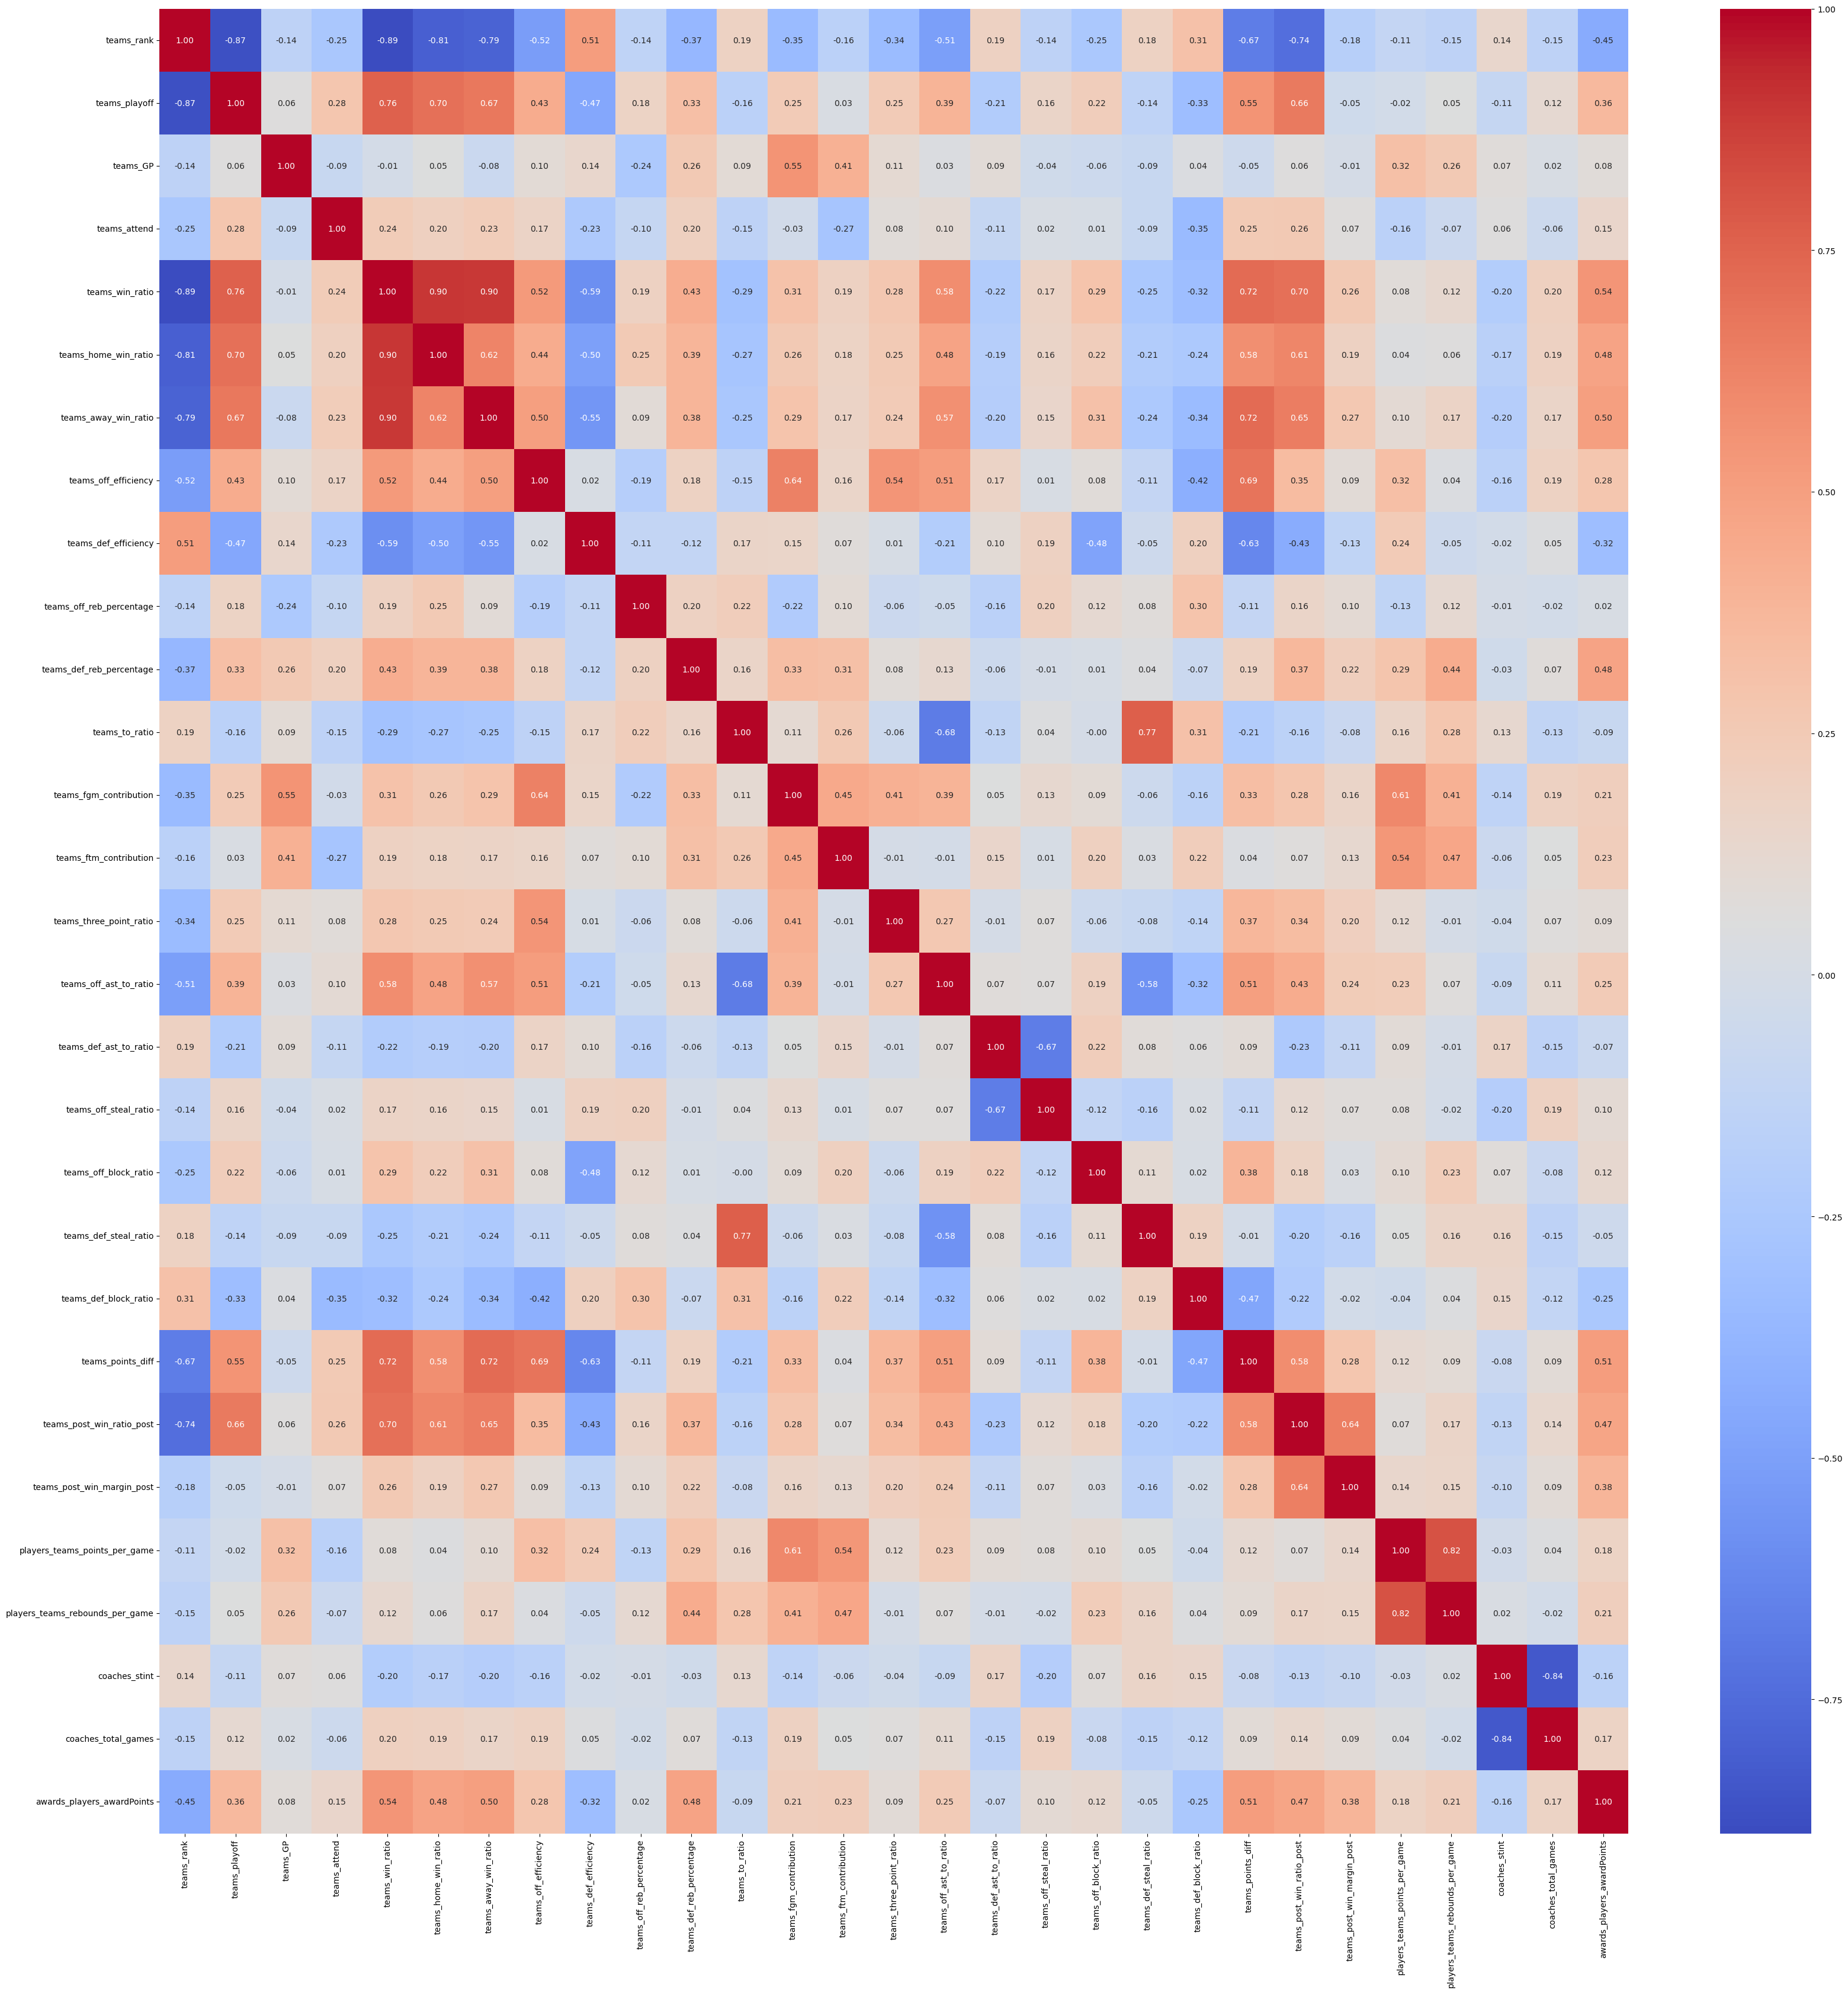

In [320]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = X_train.corr()

# Plot heatmap for correlation
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [322]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [324]:
# Example: Increase the complexity of the model
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\nakaj\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [326]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X_train_scaled, y_train, epochs=300, batch_size=16, validation_data=(X_test_scaled, y_test))


Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4140 - loss: 0.8348 - val_accuracy: 0.4545 - val_loss: 0.8455
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5512 - loss: 0.6955 - val_accuracy: 0.3939 - val_loss: 0.8144
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5625 - loss: 0.6893 - val_accuracy: 0.4242 - val_loss: 0.7936
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6457 - loss: 0.6546 - val_accuracy: 0.4242 - val_loss: 0.7824
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6537 - loss: 0.6209 - val_accuracy: 0.3939 - val_loss: 0.7714
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6758 - loss: 0.6026 - val_accuracy: 0.4242 - val_loss: 0.7643
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7390 - loss: 0.5744 - val_accuracy: 0.4545 - val_loss: 0.7614
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7545 - loss: 0.5674 - val_accuracy: 0.4848 - val_loss: 0.7612

In [328]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_accuracy}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5407 - loss: 2.2006 
Test Accuracy: 0.5454545617103577


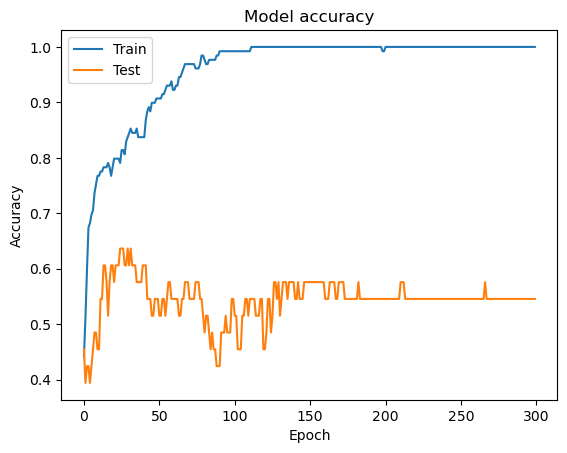

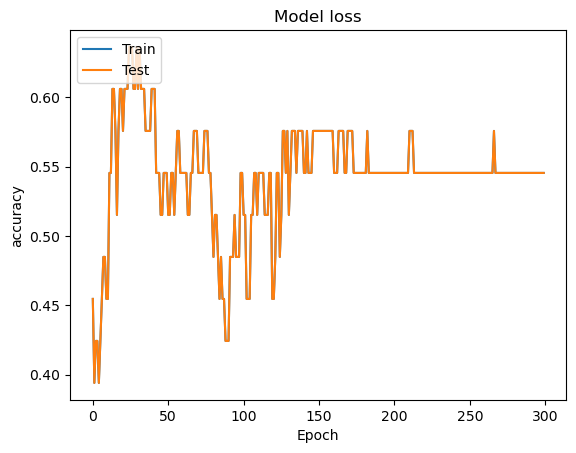

In [330]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [825]:
# Predict class labels on the test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
